# Analysis DATA

In [1]:
from utilities import *

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_data, test_data = sa.divide_data_for_train_and_test(data=data, train_size=0.8)

# convert train_data into excel file
sa.excel(train_data, path="data/train_data.xlsx")
sa.excel(test_data, path="data/test_data.xlsx")

#### Lineal-Regresion Model

In [3]:
model_brand35 = sa.modelization_with_backward_elimination(train_data)
model_brand35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           volume_sales   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     134.2
Date:                Thu, 21 Aug 2025   Prob (F-statistic):          4.22e-223
Time:                        17:22:29   Log-Likelihood:                -7343.0
No. Observations:                 644   AIC:                         1.473e+04
Df Residuals:                     620   BIC:                         1.484e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       1.21e+04   2671.315      4.530      0.000    6855.607    1.73e+04
C(supermarket)[T.supermarket-B]                                2.319e+04   9730.122      2.383      0.017    4078.902    4.23e+04
C(supermarket)[T.supermarket-D]                               -1.051e+05   1.42e+04     -7.402      0.000   -1.33e+05   -7.72e+04
C(variant)[T.standard]                                         2.624e+04   6175.874      4.249      0.000    1.41e+04    3.84e+04
C(variant)[T.vegan]                                            7.521e+04   1.85e+04      4.071      0.000    3.89e+04    1.11e+05
C(pack_size)[T.351 - 500 GR]                                    8.22e+04   5413.805     15.183      0.000    7.16e+04    9.28e+04
C(pack_size)[T.501 - 700 GR]                                   2.179e+04   3537.727      6.160      0.000    1.48e+04    2.87e+04
C(pack_size)[T.701 - 1000 GR]                                 -1.993e+04   6573.311     -3.033      0.003   -3.28e+04   -7025.422
C(supermarket)[T.supermarket-B]:C(variant)[T.light]           -1.924e+04   7704.010     -2.497      0.013   -3.44e+04   -4109.905
C(supermarket)[T.supermarket-C]:C(variant)[T.light]            3.004e+04   6014.788      4.995      0.000    1.82e+04    4.19e+04
C(supermarket)[T.supermarket-B]:C(variant)[T.standard]        -5.204e+04   7152.188     -7.276      0.000   -6.61e+04    -3.8e+04
C(supermarket)[T.supermarket-C]:C(variant)[T.standard]        -3.216e+04   5178.112     -6.210      0.000   -4.23e+04    -2.2e+04
C(supermarket)[T.supermarket-D]:C(variant)[T.standard]         6.913e+04   7708.818      8.968      0.000     5.4e+04    8.43e+04
C(supermarket)[T.supermarket-B]:C(variant)[T.vegan]            7.112e+04   1.43e+04      4.988      0.000    4.31e+04    9.91e+04
C(supermarket)[T.supermarket-C]:C(pack_size)[T.351 - 500 GR]  -3.356e+04   5564.661     -6.031      0.000   -4.45e+04   -2.26e+04
C(supermarket)[T.supermarket-D]:C(pack_size)[T.351 - 500 GR]   3.171e+04   7293.879      4.348      0.000    1.74e+04     4.6e+04
C(supermarket)[T.supermarket-D]:C(pack_size)[T.501 - 700 GR]   2.179e+04   3537.727      6.160      0.000    1.48e+04    2.87e+04
C(supermarket)[T.supermarket-B]:C(pack_size)[T.701 - 1000 GR]  5.548e+04   7817.231      7.097      0.000    4.01e+04    7.08e+04
C(variant)[T.light]:C(pack_size)[T.351 - 500 GR]               3.515e+04   9389.189      3.744      0.000    1.67e+04    5.36e+04
C(variant)[T.vegan]:C(pack_size)[T.351 - 500 GR]               9.395e-11   1.29e-11      7.287      0.000    6.86e-11    1.19e-10
C(variant)[T.light]:C(pack_size)[T.501 - 700 GR]               2.179e+04   3537.727      6.16

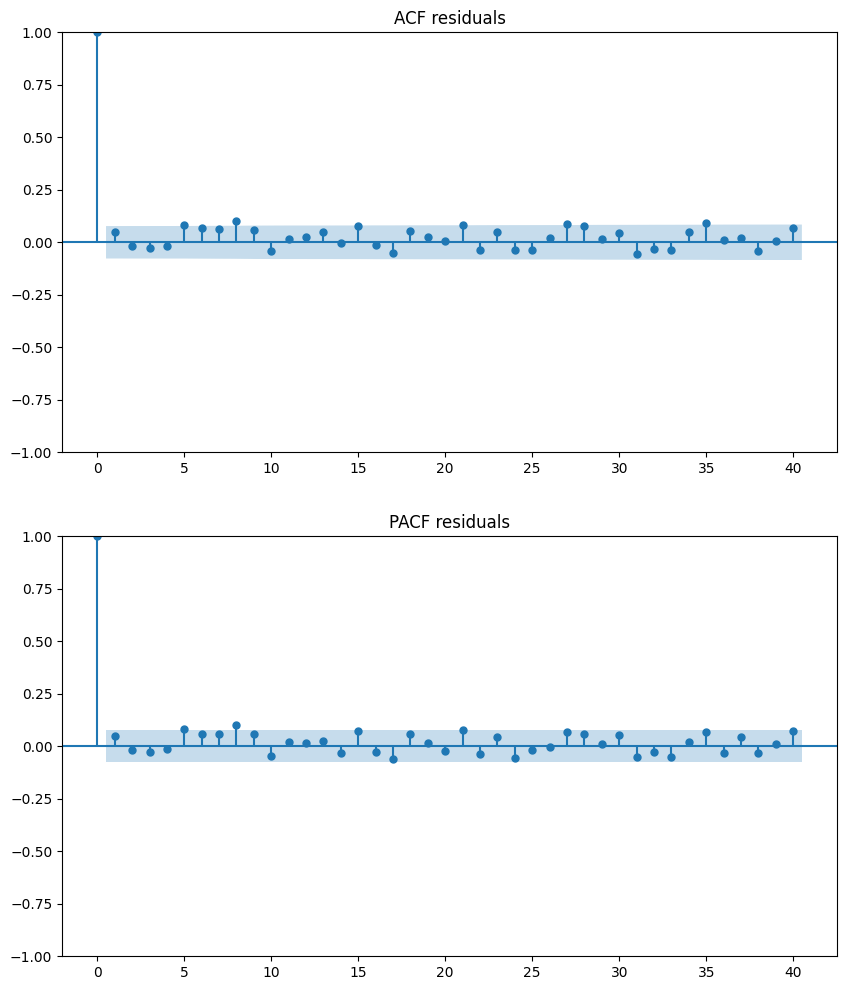

In [4]:
####RESIDUALS
sa.plot_resid_ACF_PACF(model_brand35.resid, lags=40)

##### Find the best model (ARIMA)

In [5]:
####ARIMA
"""(p, d, q)
p = (PACF)
d = diff
q = (ACF)
"""

possible_models = {
    "1": (0, 0, 5),  
    "2": (5, 0, 0),
    "3": (5, 0, 5),
}

# AIC and BIC criteria for model selection (lower is better)
for i in possible_models:
    model_arima_brand35 = sa.ARIMA(
        residues=model_brand35.resid,
        model_chosen=(possible_models[i]),
        diff_need_for_residues=False,
    )
    print("[lower is better]")
    print("------------------ AIC and BIC ----------------------")
    print(
        f"Model {i} ARIMA: {possible_models[i]} ------->",
        f"AIC: {model_arima_brand35.aic}",
        f"BIC: {model_arima_brand35.bic}",
    )
    print("----------------------------------------------------")

[lower is better]
------------------ AIC and BIC ----------------------
Model 1 ARIMA: (0, 0, 5) -------> AIC: 14691.989211670174 BIC: 14723.263102752904
----------------------------------------------------
[lower is better]
------------------ AIC and BIC ----------------------
Model 2 ARIMA: (5, 0, 0) -------> AIC: 14692.881488271447 BIC: 14724.155379354177
----------------------------------------------------
[lower is better]
------------------ AIC and BIC ----------------------
Model 3 ARIMA: (5, 0, 5) -------> AIC: 14684.627052411817 BIC: 14738.23943712507
----------------------------------------------------


In [6]:
# Check residuals for white noise
for modelo in possible_models:
    model_brand35_arima = sa.ARIMA(
        residues=model_brand35.resid,
        model_chosen=(possible_models[modelo]),
        diff_need_for_residues=False,
    )

    print("-----------------Residues Analysis (White Noise) -----------------")
    sa.residual_white_noise_test(model_brand35_arima.resid)
    print("------------------------------------------------------------------")

-----------------Residues Analysis (White Noise) -----------------
ARCH p-value: 0.0911464442373445 -- range(> 0.05)
Jarque-Bera p-value: 0.0 -- range(> 0.05)
Shapiro-Wilk p-value: 5.43913958274904e-23 -- range(> 0.05)
Ljung-Box p-value:
       lb_stat  lb_pvalue
10  14.582187   0.148053 -- range(> 0.05)
Durbin-Watson statistic: 1.9860453415537584 -- range(2.0)
------------------------------------------------------------------
-----------------Residues Analysis (White Noise) -----------------
ARCH p-value: 0.06758049581954012 -- range(> 0.05)
Jarque-Bera p-value: 0.0 -- range(> 0.05)
Shapiro-Wilk p-value: 4.3787382156345614e-23 -- range(> 0.05)
Ljung-Box p-value:
       lb_stat  lb_pvalue
10  14.814053    0.13899 -- range(> 0.05)
Durbin-Watson statistic: 2.0091338552059224 -- range(2.0)
------------------------------------------------------------------
-----------------Residues Analysis (White Noise) -----------------
ARCH p-value: 0.19745311549738206 -- range(> 0.05)
Jarque-Bera p-val

#### Autoarima

Filter data and get the best arima model for it

In [9]:
# silence warnings from pmdarima
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

#FIXME: Ensure data inputs are correctly introduced in auto_arima

filtered_train_data = train_data[
    (train_data["supermarket"] == "supermarket-A")
    & (train_data["variant"] == "flavoured")
]

filtered_test_data = test_data[
    (test_data["supermarket"] == "supermarket-A")
    & (test_data["variant"] == "flavoured")
]

auto_arima_model = auto_arima( #FIXME: Ensure if data is stationary before choosing parameter d 
    filtered_train_data["volume_sales"],
    start_p=0,
    d=1,  # Set differencing explicitly instead of None
    start_q=0,
    max_p=3, 
    max_q=3,
    start_P=0,
    D=1,  # Set seasonal differencing explicitly
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,  # Monthly data
    seasonal=True,
    trace=True,
    error_action="warn",  # Change to warn to see potential issues
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    information_criterion='aic'
)

# Print the best model and its parameters
print("Best model parameters:", auto_arima_model.order)
print("Best seasonal parameters:", auto_arima_model.seasonal_order)
print("AIC:", auto_arima_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=297.456, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=300.602, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=300.563, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=299.069, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=298.687, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=300.488, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=299.141, Time=0.00 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=299.291, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=299.184, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=299.440, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.214 seconds
Best model parameters: (0, 1, 0)
Best seasonal parameters: (0, 1, 0, 12)
AIC: 297.45647128978203


#### FORECASTING

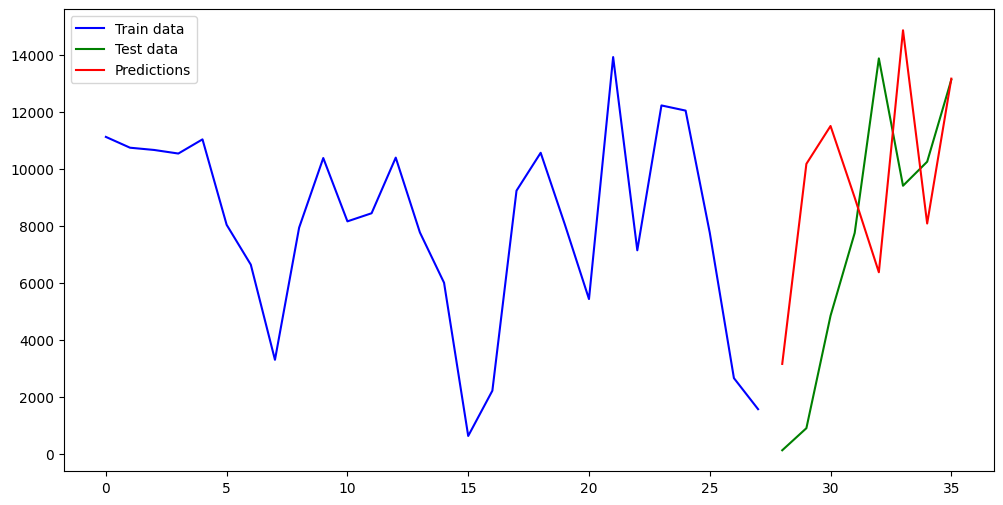

In [12]:
predictions = pd.DataFrame(
    auto_arima_model.predict(n_periods=len(filtered_test_data)),
    index=filtered_test_data.index,
    columns=["Predicted Volume Sales"],
)
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_train_data["volume_sales"], #FIXME: change volume_sales to volume.sales or vice versa
    label="Train data",
    color="blue",
)
plt.plot(
    filtered_test_data["volume.sales"],
    label="Test data",
    color="green",
)
plt.plot(
    predictions["Predicted Volume Sales"],
    label="Predictions",
    color="red",
)
plt.legend()
plt.show()